<a href="https://colab.research.google.com/github/julianaddison/gen-ai-rag/blob/main/PolicyPal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PolicyPal**
 PolicyPal is a demo chatbot experience to redefine the way users engage with insurance. Say goodbye to complicated forms and confusing jargon – with PolicyPal, obtaining insurance information becomes as easy as having a conversation.

 This demo utilizes Retrieval-Augmented Generation (RAG) on an open-source [insurance Q&A corpus](https://github.com/shuzi/insuranceQA/tree/master) with real-world user questions on various insurance domains.

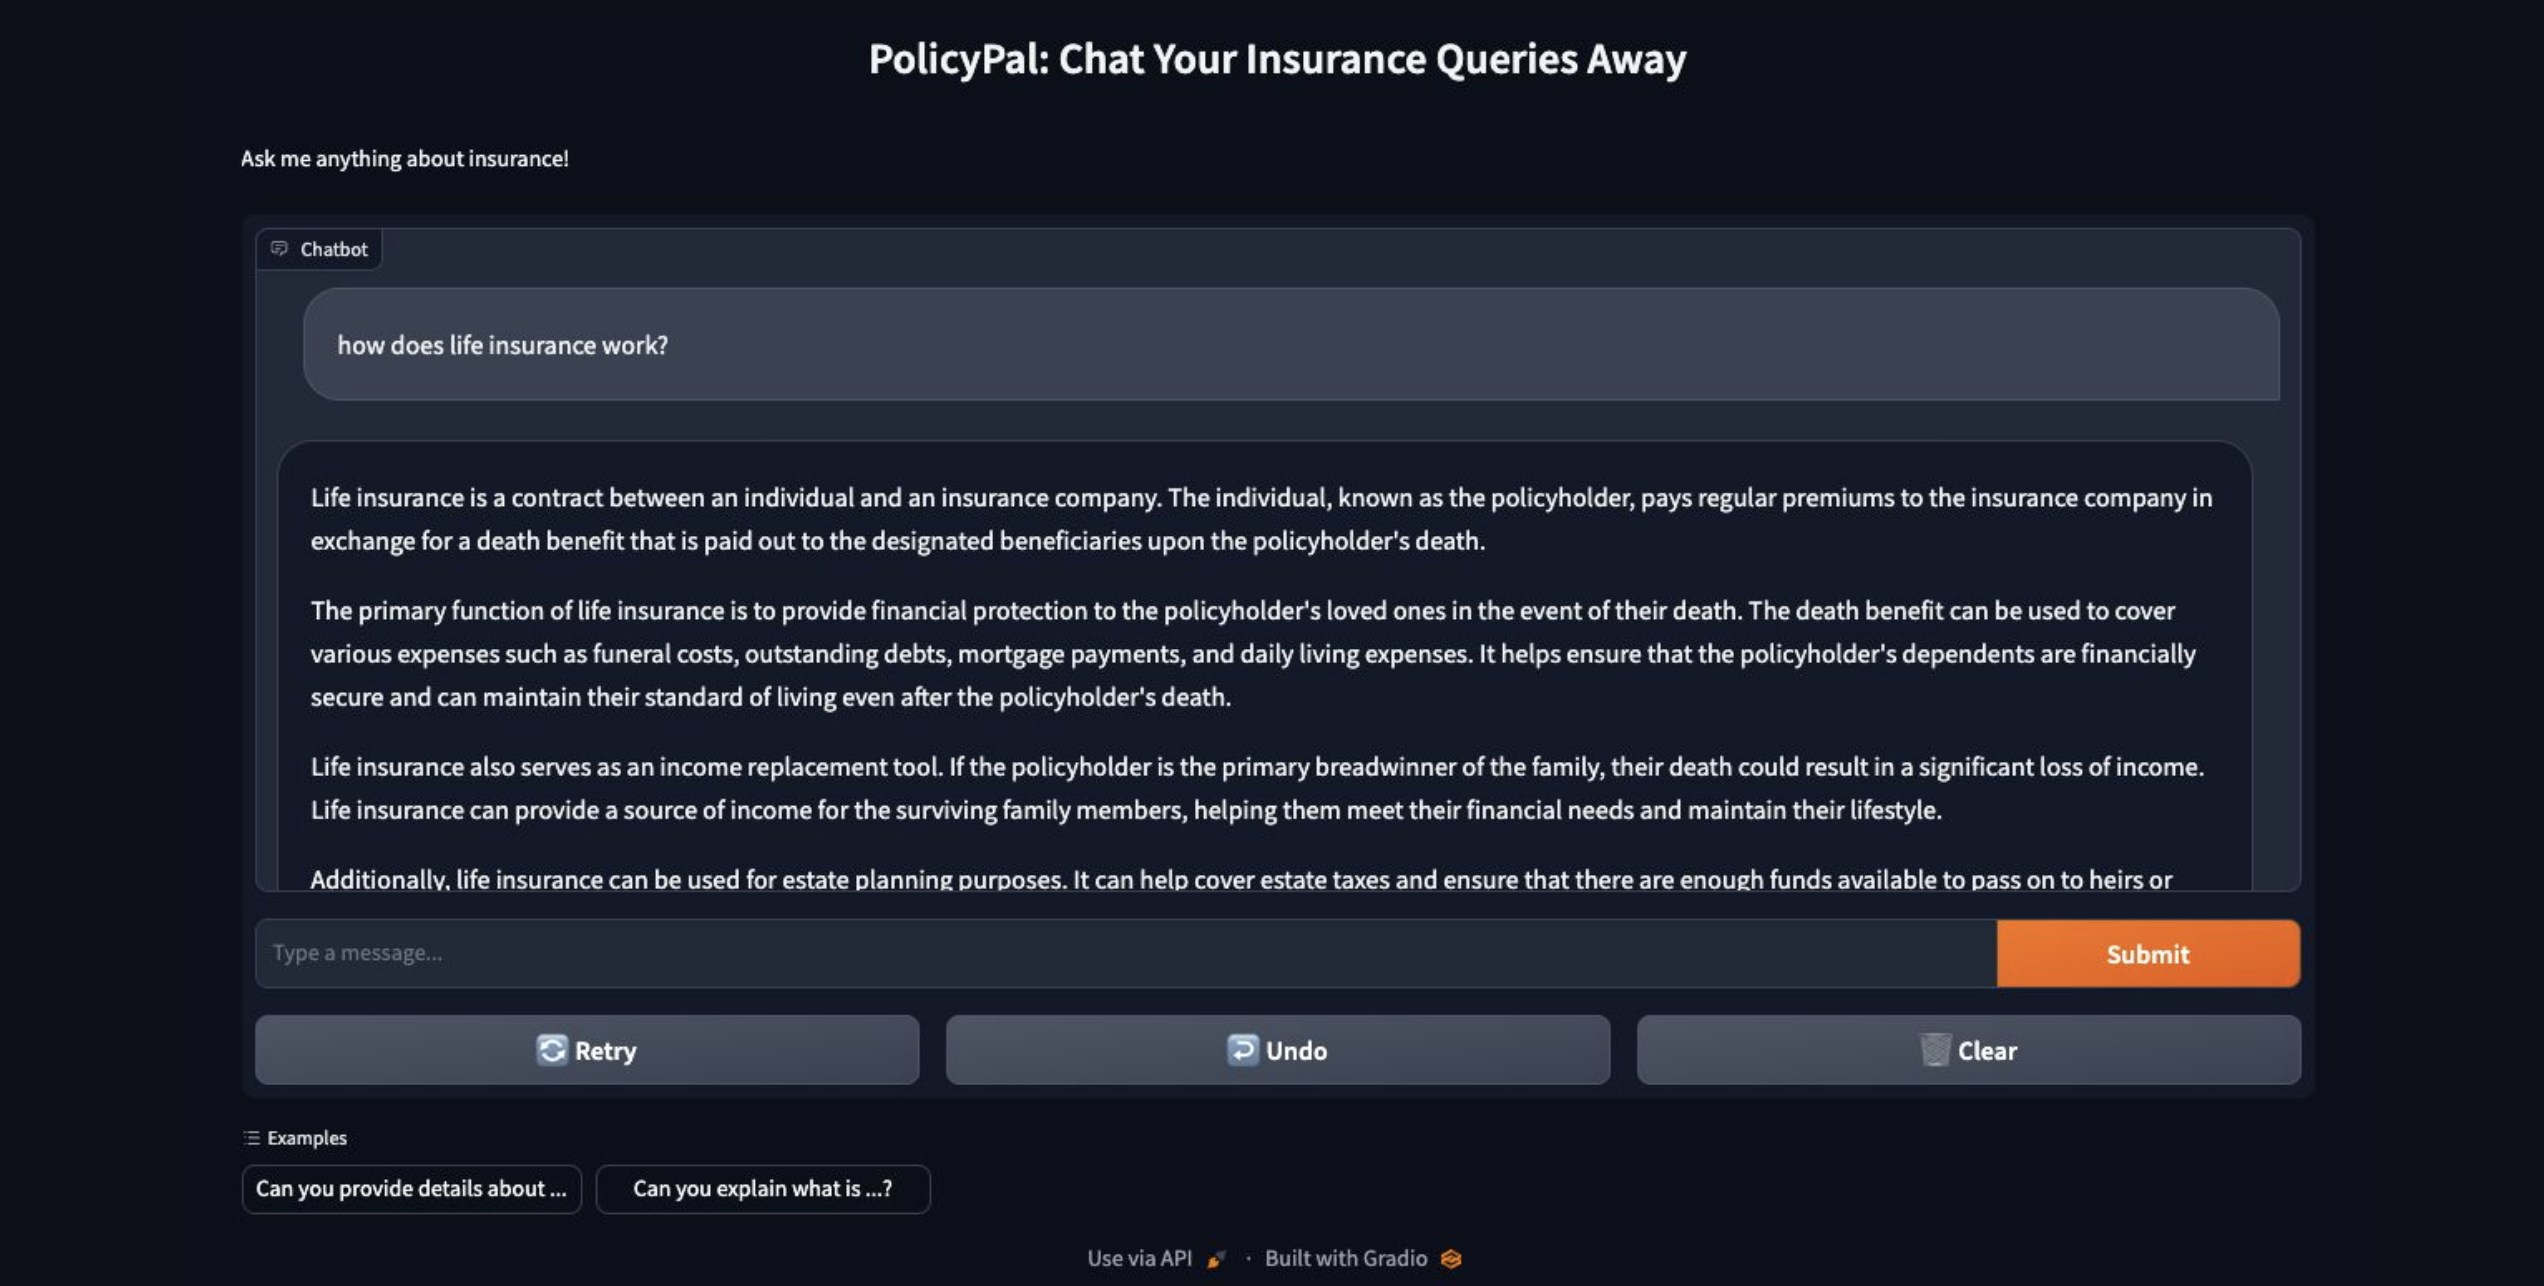

## What are RAGs?
Retrieval-Augmented Generation (RAG) is an approach in natural language processing that combines the strengths of both retrieval-based models and generative models.

It is the concept to provide LLMs with additional information from an external knowledge source which allows them to generate more accurate and contextual answers while reducing hallucinations

In the context of question answering, for example, a retrieval model might identify relevant passages or documents containing potential answers. The generative model then takes this retrieved context and generates a more detailed and coherent response. This combination can lead to more accurate and contextually relevant answers, especially in situations where the answer might not be directly present in the training data of the generative model.

## Tech Stack
In this notebook, a RAG pipeline in Python is implemented using OpenAI's LLM in combination with a Weaviate vector database and an OpenAI embedding model. LangChain is used for orchestration with Gradio's ChatBot module used as a simple web user interface.

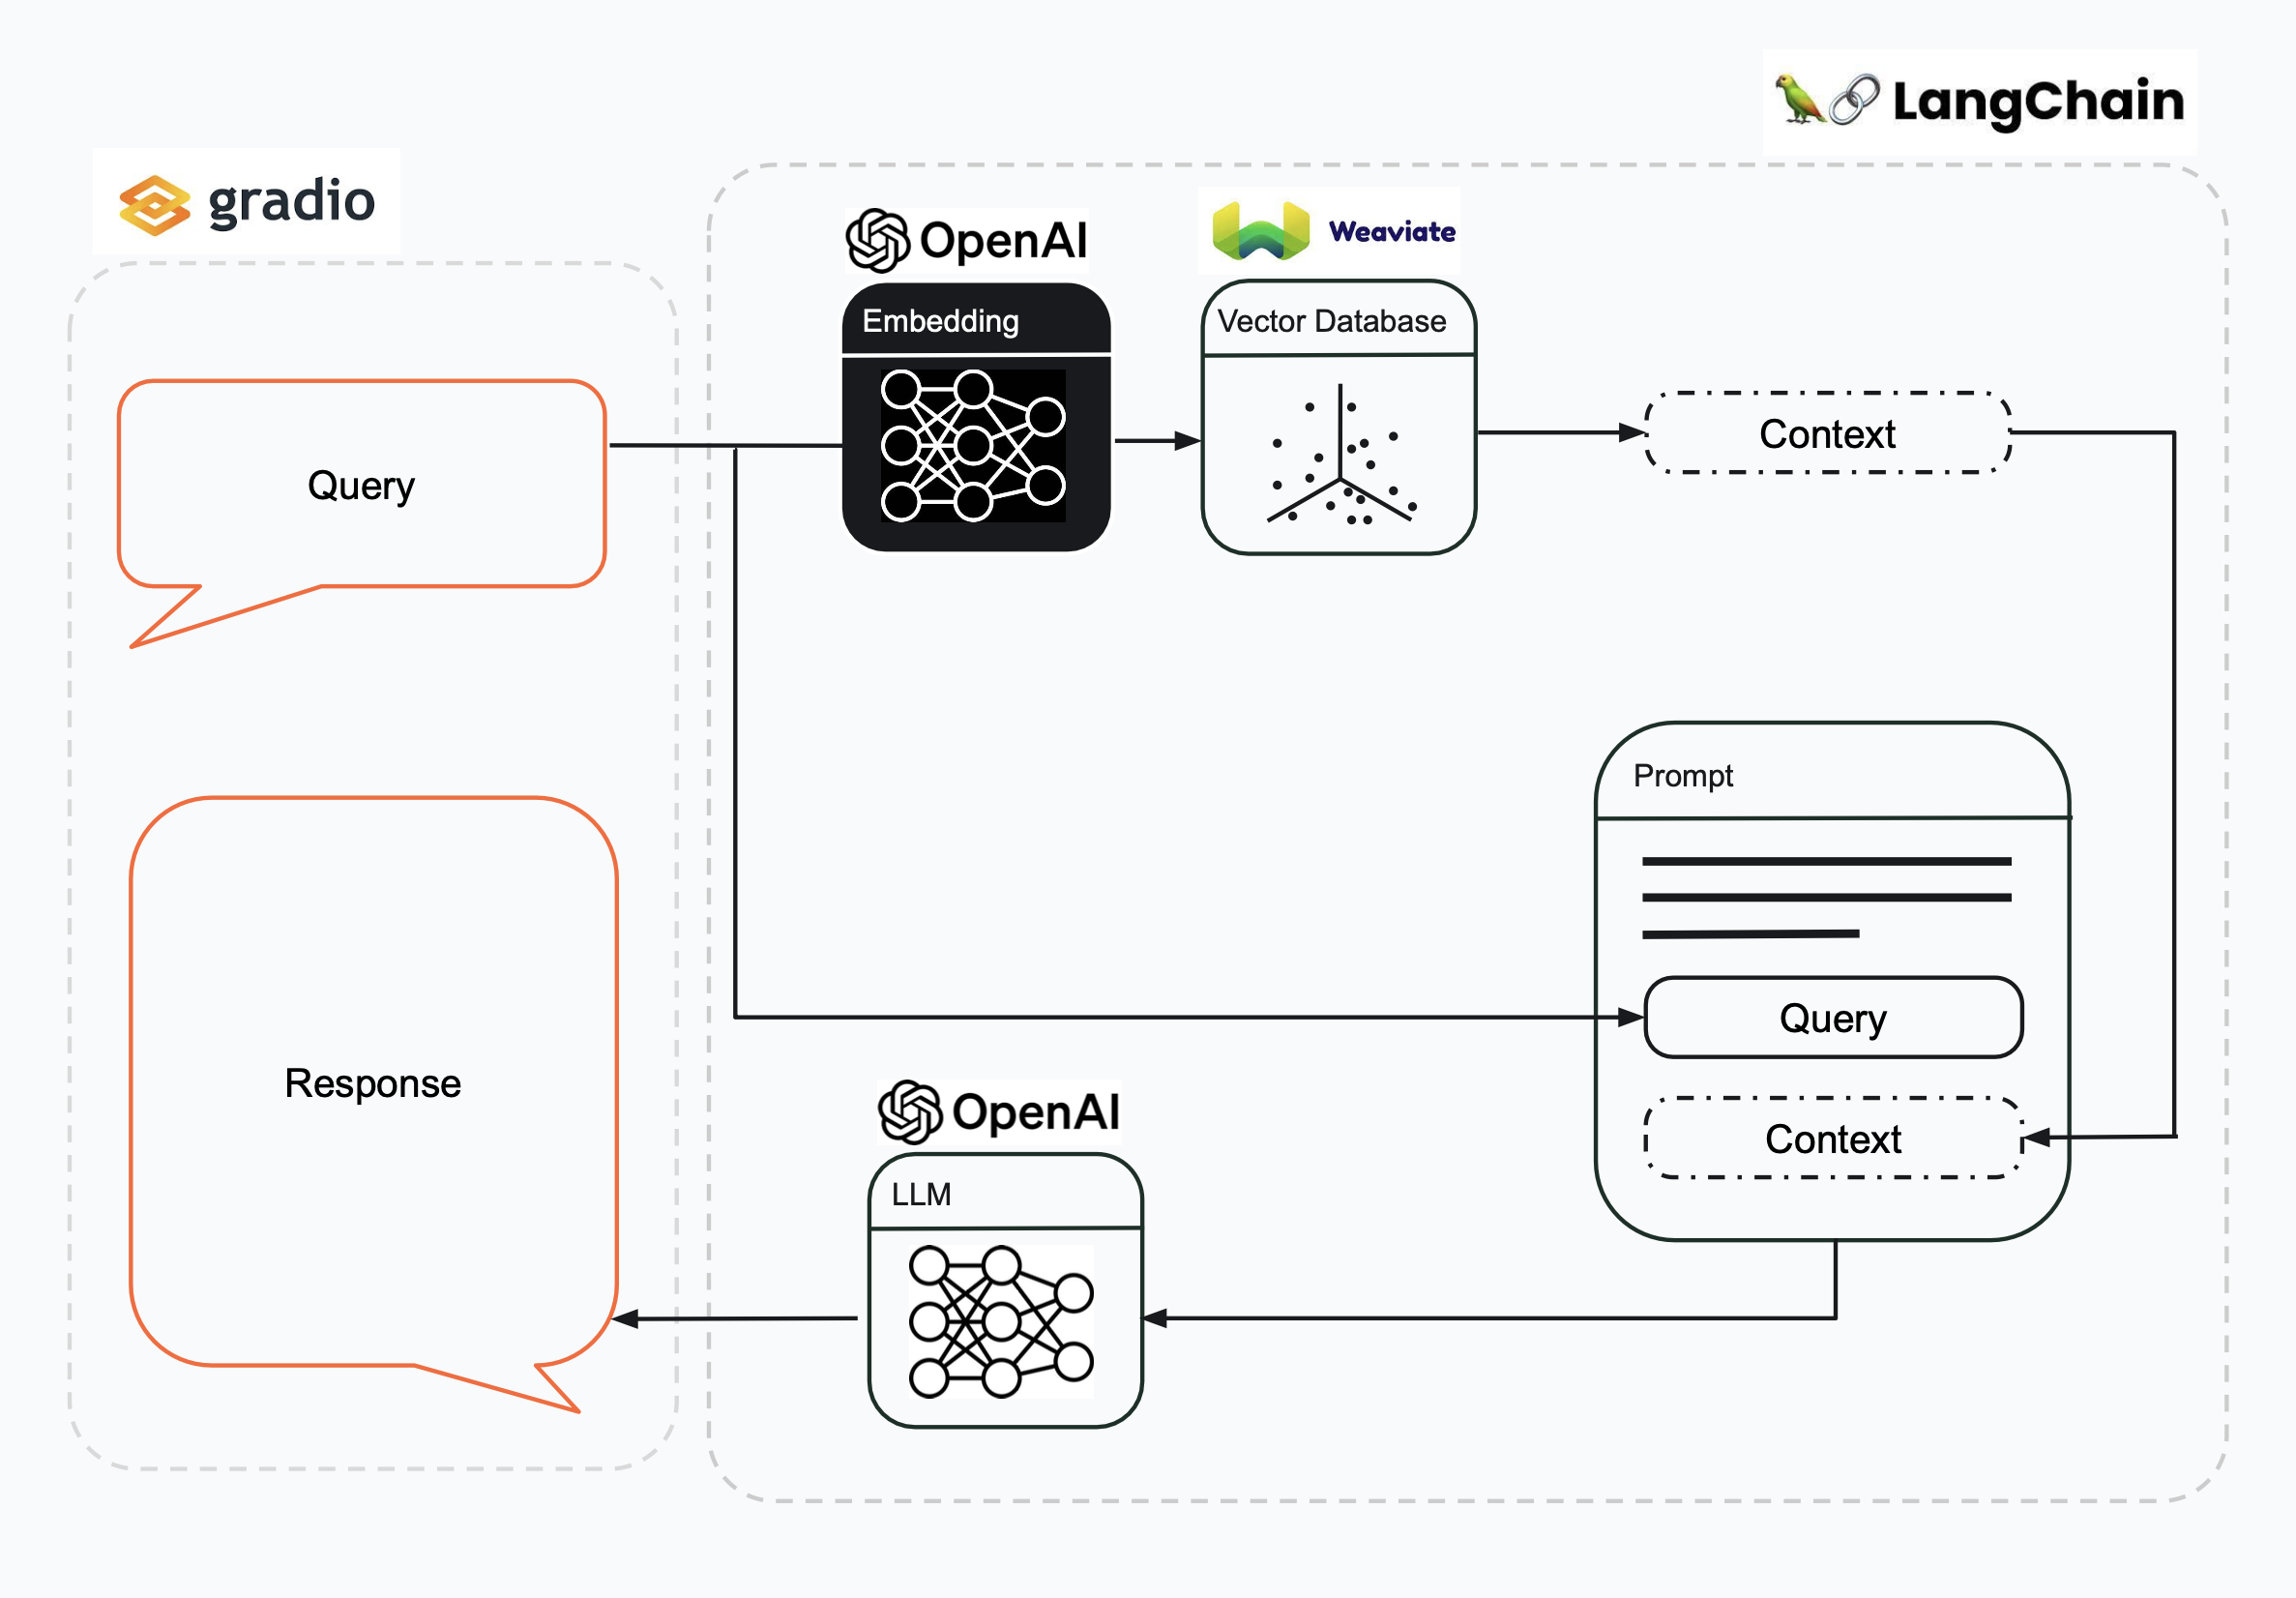

1.   **Retrieve**: The user query is used to retrieve relevant context from an external knowledge source. For this, the user query is embedded with an embedding model into the same vector space as the additional context in the vector database. This allows to perform a similarity search, and the top k closest data objects from the vector database are returned.

2.   **Augment**: The user query and the retrieved additional context are stuffed into a prompt template.

3. **Generate**: Finally, the retrieval-augmented prompt is fed to the LLM.

## Prerequisites
You will need to have the following before continuing:

*   **OpenAI API key**: We will generate embeddings from text via OpenAI's inference service. The Ada model (version 2) costs \$0.0001 per 1,000 tokens. For this demo, the embedding of a subset of the InsuranceCorpus was \$0.23.
*   **Weaviate API key and cluster URL**: Run a Weaviate instance as a managed service using Weaviate Cloud Services (WCS). The free trial plan provides a sandbox for 14 days. No payment information is required. The sandbox expires after the trial period but a new free trial sandbox can be created anytime. Refer to the **Setup** section in this [article](https://towardsdatascience.com/getting-started-with-weaviate-a-beginners-guide-to-search-with-vector-databases-14bbb9285839) for more information.

Store the keys and url in Google Collab Secrets. Refer to this [article](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75) on how to store the keys.

# Let's Get Started



## Dependencies

Install the required Python packages:

- LangChain for orchestration :: LangChain is a framework for developing applications powered by language models.
- OpenAI for the embedding model and LLM
- Weaviate-client for the vector database :: Weaviate is an open-source vector database. It allows you to store data objects and vector embeddings from your favorite ML-models, and scale seamlessly into billions of data objects.
- Gradio for to deploy and serve the RAG through a web user interface

In [ ]:
!pip install langchain openai weaviate-client tiktoken gradio==3.47.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.3/120.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.3 M

## Data Preparation

In [ ]:
import os

import pandas as pd
import weaviate
from weaviate.util import generate_uuid5

In [ ]:
def read_txt_file(file_path):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
        return content
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [ ]:
# load data
datapath = "/content/drive/MyDrive/Colab Notebooks/LLMs/data"

vocab_fn = "vocabulary.txt"
question_fn = "InsuranceQA.question.anslabel.token.encoded"
ans_fn = "InsuranceQA.label2answer.token.encoded"

vocab = read_txt_file(os.path.join(datapath, vocab_fn))

In [ ]:
# Step 1: Create a dictionary to map index values to words
index_to_word = {}
with open(os.path.join(datapath, vocab_fn), 'r', encoding='utf-8') as vocab_file:
    for line in vocab_file:
        index, word = line.strip().split('\t')
        index_to_word[index] = word

In [ ]:
# Step 2: Iterate through the questions file and replace index values with words
questions_to_word = []
with open(os.path.join(datapath, question_fn), 'r', encoding='utf-8') as questions_file:
  for line in questions_file:
    questions_to_word_record = {}

    parts = line.strip().split('\t')
    domain, words_in_index_form, labels = parts[:3]

    # Replace index values with words
    words_in_index_form = ' '.join(index_to_word.get(index, '') for index in words_in_index_form.split())
    # print(words_in_index_form)

    questions_to_word_record['Domain'] = domain
    questions_to_word_record['Question'] = words_in_index_form
    questions_to_word_record['GT'] = labels

    questions_to_word.append(questions_to_word_record)

In [ ]:
# check number of questions
len(questions_to_word)

16889

In [ ]:
# Step 3: Iterate through the answers file and replace index values with words
answers_to_word = []
with open(os.path.join(datapath, ans_fn), 'r', encoding='utf-8') as answers_file:
  for line in answers_file:
    answers_to_word_record = {}

    parts = line.strip().split('\t')
    label, words_in_index_form = parts[:2]

    # Replace index values with words
    words_in_index_form = ' '.join(index_to_word.get(index, '') for index in words_in_index_form.split())
    # print(words_in_index_form)

    answers_to_word_record['Answer'] = words_in_index_form
    answers_to_word_record['GT'] = label

    answers_to_word.append(answers_to_word_record)

In [ ]:
# check number of words
len(answers_to_word)

27413

In [ ]:
# Step 4: Test question and answer pairs - Note a question can have multiple answers
idx = 11195
print("QUESTION:")
print(questions_to_word[idx])
print()

print("ANSWER/s:")
for i in questions_to_word[idx]['GT'].split(' '):
  print(i, '==>', answers_to_word[int(i)-1])

QUESTION:
{'Domain': 'auto-insurance', 'Question': "Can You Put Insurance On A Car That Is n't Yours ?", 'GT': '22394 1'}

ANSWER/s:
22394 ==> {'Answer': "No , because you do not have an insurable interest in the vehicle . You could purchase a `` Non-owned auto policy '' though . This would provide you with liability protection when you drive a vehicle but do not own one yourself . Contact a local agent to find out about coverage availability and pricing in your area .", 'GT': '22394'}
1 ==> {'Answer': "Coverage follows the car . Example 1 : If you were given a car -LRB- loaned -RRB- and the car has no insurance , you can buy insurance on the car and your insurance will be primary . Another option , someone helped you to buy a car . For example your credit score is n't good enough to finance , so a friend of yours signed under your loan as a primary payor . You can get insurance under your name and even list your friend on the policy as a loss payee . In this case , we always suggest y

In [ ]:
idx = 11248
print("QUESTION:")
print(questions_to_word[idx])
print()

print("ANSWER/s:")
for i in questions_to_word[idx]['GT'].split(' '):
  print(i, '==>', answers_to_word[int(i)-1])

QUESTION:
{'Domain': 'life-insurance', 'Question': 'How Much Is Term Life Insurance ?', 'GT': '9921 13604 5878 18067 22541'}

ANSWER/s:
9921 ==> {'Answer': "The cost will depend upon several things - the company , the length of the term , the amount of coverage , your age , health , etc. . I 'd advise that you contact some local agents with some specific details , and shop around for some quotes . If you would like some help with this , please hit the ` contact me ' button , and I 'll happily help . Thanks for asking !", 'GT': '9921'}
13604 ==> {'Answer': "Unfortunately there 's too many factors that go into premium pricing to give a definitive answer as to what a term plan costs . The risk class is the most critical factor in determining the cost -LRB- premium -RRB- of a life insurance policy . The risk class depends ona number of factors including whether you 're male or female , your medical history , height/weight profile , any tobacco usage , and other factors . Keep in mind , eve

In [ ]:
# Step 5: Create a df
qna_df = pd.DataFrame(questions_to_word)
qna_df['Answer'] = ''

for id, row in qna_df.iterrows():
  a_ids = row.GT.split(' ')
  ans_ls = []
  for a_id in a_ids:
    try:
      ans_ls.append(answers_to_word[int(a_id)-1]['Answer'])
    except IndexError as e:
      print('ROW: ', id, 'ANS ID: ', a_id)
      continue

  # update answer
  qna_df.at[id, 'Answer'] = ans_ls

In [ ]:
# Check Q&A dataframe
qna_df

,Domain,Question,GT,Answer
0,medicare-insurance,What Does Medicare IME Stand For ?,16696,[According to the Centers for Medicare and Med...
1,long-term-care-insurance,Is Long Term Care Insurance Tax Free ?,10277,"[As a rule , if you buy a tax qualified long t..."
2,health-insurance,Can Husband Drop Wife From Health Insurance ?,12076,[Can a spouse drop another spouse from health ...
3,medicare-insurance,Is Medicare Run By The Government ?,25578 6215,[Medicare Part A and Part B is provided by the...
4,medicare-insurance,Does Medicare Cover Co-Pays ?,22643,[Original Medicare Part A & Medicare Part B do...
...,...,...,...,...
16884,life-insurance,Who Needs Life Insurance And Why ?,7867,[Anyone who has a family that they care about ...
16885,disability-insurance,How Much Disability Insurance Should You Buy ?,3766 10908,[How much disbility insurance should you buy ?...
16886,home-insurance,Why Do We Need Homeowners Insurance ?,4308 6453,[There isnt a legal obligation to own homeowne...
16887,life-insurance,What Does A Life Insurance Drug Test Test For ?,4693,[Some life insurance companies have been incre...


In [ ]:
qna_df[15:17]

,Domain,Question,GT,Answer
15,annuities,How Do Annuities Earn Money ?,24051,[There are three basic types of crediting meth...
16,retirement-plans,What Is A Qualified Retirement Plan ?,17011 26945,[A qualified plan is generally a government sa...


## Create Weaviate DB

In [ ]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OpenAIKey')
WEAVIATE_API_KEY = userdata.get('WeaviateKey')
WEAVIATE_CLUSTER_URL = userdata.get('WeaviateURL')

In [ ]:
# Weaviate instance API key
auth_config = weaviate.AuthApiKey(api_key=WEAVIATE_API_KEY)  # Replace w/ your Weaviate instance API key

# Instantiate the client
client = weaviate.Client(
    url=WEAVIATE_CLUSTER_URL, # Replace w/ your Weaviate cluster URL
    auth_client_secret=auth_config,
    additional_headers={
        "X-OpenAI-Api-Key": OPENAI_API_KEY, # Replace with your OpenAI key
        }
)

In [ ]:
# check if everything is set up correctly --> returns True if correct
client.is_ready()

True

### Step 1: Create Schema

In [ ]:
class_obj = {
    # Class definition
    "class": "InsuranceCorpusQA",

    # Property definitions
    "properties": [
        {
            "name": "domain",
            "dataType": ["text"],
        },
        {
            "name": "question",
            "dataType": ["text"],
        },
        {
            "name": "answer",
            "dataType": ["text"],
            "cardinality": "many",  # Use "many" for multiple answers
        },
    ],

    # Specify a vectorizer
    "vectorizer": "text2vec-openai",

    # Module settings
    "moduleConfig": {
        "text2vec-openai": {
            "vectorizeClassName": False,
            "model": "ada",
            "modelVersion": "002",
            "type": "text",
            "multi": True,  # Use "multi" for multiple answers

        },
        "qna-openai": {
          "model": "text-davinci-002"
        },
        "generative-openai": {
          "model": "gpt-3.5-turbo"
        }
    },
}

# Create schema
client.schema.create_class(class_obj)

In [ ]:
# check by reviewing schema
client.schema.get("InsuranceCorpusQA")

{'class': 'InsuranceCorpusQA',
 'invertedIndexConfig': {'bm25': {'b': 0.75, 'k1': 1.2},
  'cleanupIntervalSeconds': 60,
  'stopwords': {'additions': None, 'preset': 'en', 'removals': None}},
 'moduleConfig': {'generative-openai': {'model': 'gpt-3.5-turbo'},
  'qna-openai': {'model': 'text-davinci-002'},
  'text2vec-openai': {'baseURL': 'https://api.openai.com',
   'model': 'ada',
   'modelVersion': '002',
   'multi': True,
   'type': 'text',
   'vectorizeClassName': False}},
 'multiTenancyConfig': {'enabled': False},
 'properties': [{'dataType': ['text'],
   'indexFilterable': True,
   'indexSearchable': True,
   'moduleConfig': {'text2vec-openai': {'skip': False,
     'vectorizePropertyName': False}},
   'name': 'domain',
   'tokenization': 'word'},
  {'dataType': ['text'],
   'indexFilterable': True,
   'indexSearchable': True,
   'moduleConfig': {'text2vec-openai': {'skip': False,
     'vectorizePropertyName': False}},
   'name': 'question',
   'tokenization': 'word'},
  {'dataType'

### Step 2: Import data into Weaviate


In [ ]:
# Only a subset of the data was uploaded - approx 15603 question-answer pairs
# To upload the full dataset you will need to modify batch_size and num_workers or
# creat a sleep workaround to meet OpenAI's rate limits.
# See https://platform.openai.com/docs/guides/rate-limits?context=tier-free
with client.batch(
    batch_size=200,  # Specify batch size
    num_workers=2,   # Parallelize the process
) as batch:
    for i, row in qna_df.iterrows():

      for answer in row['Answer']:
          question_object = {
              "category": row.Domain,
              "question": row.Question,
              "answer": answer
          }

          batch.add_data_object(
              question_object,
              class_name="InsuranceCorpusQA",
              uuid=generate_uuid5(question_object)
              )

In [ ]:
# check to review the number of imported objects
client.query.aggregate("InsuranceCorpusQA").with_meta_count().do()

{'data': {'Aggregate': {'InsuranceCorpusQA': [{'meta': {'count': 15603}}]}}}

## RAG using LangChain for Orchestration

In [ ]:
from langchain.embeddings import OpenAIEmbeddings

import weaviate
# from langchain.chat_models import ChatOpenAI
from langchain_community.chat_models import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain.llms import OpenAI

from langchain.vectorstores import Weaviate

### Step 1: Retrieve

In [ ]:
from google.colab import userdata

OPENAI_API_KEY = userdata.get('OpenAIKey')
WEAVIATE_API_KEY = userdata.get('WeaviateKey')
WEAVIATE_CLUSTER_URL = userdata.get('WeaviateURL')

In [ ]:
# Weaviate instance API key
auth_config = weaviate.AuthApiKey(api_key=WEAVIATE_API_KEY)  # Replace w/ your Weaviate instance API key

# Instantiate the client
client = weaviate.Client(
    url=WEAVIATE_CLUSTER_URL, # Replace w/ your Weaviate cluster URL
    auth_client_secret=auth_config,
    additional_headers={
        "X-OpenAI-Api-Key": OPENAI_API_KEY, # Replace with your OpenAI key
        }
)

In [ ]:
vectorstore = Weaviate(client, index_name="InsuranceCorpusQA", text_key="question")

In [ ]:
# Define the retriever component
retriever = vectorstore.as_retriever(
    class_name="InsuranceCorpusQA",  # Class containing question-answer pairs
    property_name="question",  # Property used for semantic search
    embedding_module="text2vec-openai",  # Vectorizer used in Weaviate
)

### Step 2: Augment

In [ ]:
from langchain.prompts import ChatPromptTemplate

# template = """You are an assistant for question-answering tasks.
# Use the following pieces of retrieved context to answer the question.
# If you don't know the answer, just say that you don't know.
# Use three sentences maximum and keep the answer concise.
# Question: {question}
# Context: {context}
# Answer:
# """

template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Be detailed in your answer.
Question: {question}
Context: {context}
Answer:
"""
prompt = ChatPromptTemplate.from_template(template)

print(prompt)

input_variables=['context', 'question'] messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. \nUse the following pieces of retrieved context to answer the question. \nIf you don't know the answer, just say that you don't know. \nBe detailed in your answer.\nQuestion: {question} \nContext: {context} \nAnswer:\n"))]


### Step 3: Generate

In [ ]:
# Initialize the ChatPromptTemplate
# prompt_template = ChatPromptTemplate(llm=OpenAI(temperature=0.7,
#                                                 openai_api_key=OPENAI_API_KEY),  # Adjust temperature as needed
# )

llm = ChatOpenAI(model_name="gpt-3.5-turbo",
                 temperature=0,
                 openai_api_key=OPENAI_API_KEY)

rag_chain = (
    {"context": retriever,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

query = "Can I Drop my Wife From Health Insurance?"
rag_chain.invoke(query)

# # Example usage within a RAG pipeline (details below):
# retrieved_contexts = retriever.retrieve(query="Are there any tests required for life insurance?", domain="life-insurance")
# augmented_prompt = prompt_template.augment(query, retrieved_contexts)
# answer = llm.generate_text(augmented_prompt)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:189: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use langchain_openai.ChatOpenAI instead.
  warn_deprecated(


'Based on the retrieved context, it seems that the question is about dropping a spouse from health insurance. The context includes multiple documents discussing the possibility of dropping a husband or wife from health insurance. However, without further information or specific details about the situation, it is difficult to provide a definitive answer. \n\nIn general, the ability to drop a spouse from health insurance depends on various factors, such as the type of health insurance plan, the terms and conditions of the policy, and any applicable laws or regulations. It is recommended to review the specific health insurance policy or contact the insurance provider directly to understand the options and requirements for removing a spouse from coverage.'

In [ ]:
query = "Are there any tests required for life insurance? What are they?"
response = rag_chain.invoke(query)
response

"Yes, there are tests required for life insurance. The specific tests that are conducted may vary depending on the insurance company and the type of policy being applied for. One common test is a medical exam, which typically includes measurements of height, weight, blood pressure, and a blood and urine sample. The purpose of this exam is to assess the applicant's overall health and identify any pre-existing medical conditions that may affect their eligibility or premium rates. Additionally, the medical exam may also involve a review of the applicant's medical history and lifestyle factors such as smoking or alcohol consumption. In some cases, more specialized tests such as an electrocardiogram (ECG) or a stress test may be required, especially for older applicants or those with certain risk factors. It is important to note that not all life insurance policies require a medical exam, as there are also options available such as no-exam or simplified issue policies that have less stringe

## Deploying RAG in Gradio
Implement a function that rebuilds the storage context, loads the index, and queries it with an input text.

### Q&A Gradio Standard Interface

In [ ]:
import time

import weaviate

from langchain.embeddings import OpenAIEmbeddings
from langchain_community.chat_models import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain.llms import OpenAI

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)

from langchain.vectorstores import Weaviate
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

import gradio as gr

from google.colab import userdata

In [ ]:
def instantiate_vectorstore(weaviate_api_key, weaviate_cluster_url, openai_api_key):

  # Weaviate instance API key
  auth_config = weaviate.AuthApiKey(api_key=weaviate_api_key)  # Replace w/ your Weaviate instance API key

  # Instantiate the client
  client = weaviate.Client(
      url=weaviate_cluster_url, # Replace w/ your Weaviate cluster URL
      auth_client_secret=auth_config,
      additional_headers={
          "X-OpenAI-Api-Key": openai_api_key, # Replace with your OpenAI key
          }
      )
  return client


def qna_querying(query:str):

  weaviate_api_key = WEAVIATE_API_KEY
  weaviate_cluster_url = WEAVIATE_CLUSTER_URL
  openai_api_key = OPENAI_API_KEY
  weaviate_vectorstore_name = WEAVIATE_VECTORSTORE_NAME
  weaviate_property_name = WEAVIATE_PROPERTY_NAME

  # Step 1: Retrieve
  vectorstore = Weaviate(client,
                         index_name=weaviate_vectorstore_name,
                         text_key=weaviate_property_name)

  # Define the retriever component
  retriever = vectorstore.as_retriever(
      class_name=weaviate_vectorstore_name,  # Class containing question-answer pairs
      property_name=weaviate_property_name,  # Property used for semantic search
      embedding_module="text2vec-openai",  # Vectorizer used in Weaviate
      )

  # Step 2: Augment
  template = """You are an assistant for question-answering tasks.
  Use the following pieces of retrieved context to answer the question.
  If you don't know the answer, just say that you don't know.
  Be detailed in your answer.
  Question: {question}
  Context: {context}
  Answer:
  """

  prompt = ChatPromptTemplate.from_template(template)

  # Initialise the LLM
  llm = ChatOpenAI(model_name="gpt-3.5-turbo",
                   temperature=0,
                   openai_api_key=OPENAI_API_KEY)

  rag_chain = (
      {"context": retriever,  "question": RunnablePassthrough()}
      | prompt
      | llm
      | StrOutputParser()
  )

  # Step 3: Generate
  # query = "Can I Drop my Wife From Health Insurance?"
  response = rag_chain.invoke(query)

  return response

In [ ]:
OPENAI_API_KEY = userdata.get('OpenAIKey')
WEAVIATE_API_KEY = userdata.get('WeaviateKey')
WEAVIATE_CLUSTER_URL = userdata.get('WeaviateURL')
WEAVIATE_VECTORSTORE_NAME = "InsuranceCorpusQA"
WEAVIATE_PROPERTY_NAME = "question"

In [ ]:
client = instantiate_vectorstore(WEAVIATE_API_KEY, WEAVIATE_CLUSTER_URL, OPENAI_API_KEY)

iface = gr.Interface(
    fn=qna_querying,
    inputs=gr.components.Textbox(lines=3, label="Enter your question"),
    outputs="text",
    title="Ask Me Anything About Insurance")

iface.launch(share=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

### Q&A Gradio Standard Interface using LangChain ConversationalRetrievalChain

In [ ]:
def instantiate_vectorstore(weaviate_api_key, weaviate_cluster_url, openai_api_key):

  # Weaviate instance API key
  auth_config = weaviate.AuthApiKey(api_key=weaviate_api_key)  # Replace w/ your Weaviate instance API key

  # Instantiate the client
  client = weaviate.Client(
      url=weaviate_cluster_url, # Replace w/ your Weaviate cluster URL
      auth_client_secret=auth_config,
      additional_headers={
          "X-OpenAI-Api-Key": openai_api_key, # Replace with your OpenAI key
          }
      )
  return client

In [ ]:
OPENAI_API_KEY = userdata.get('OpenAIKey')
WEAVIATE_API_KEY = userdata.get('WeaviateKey')
WEAVIATE_CLUSTER_URL = userdata.get('WeaviateURL')
WEAVIATE_VECTORSTORE_NAME = "InsuranceCorpusQA"
WEAVIATE_PROPERTY_NAME = "question"

In [ ]:
weaviate_api_key = WEAVIATE_API_KEY
weaviate_cluster_url = WEAVIATE_CLUSTER_URL
openai_api_key = OPENAI_API_KEY
weaviate_vectorstore_name = WEAVIATE_VECTORSTORE_NAME
weaviate_property_name = WEAVIATE_PROPERTY_NAME

# Step 1: Retrieve
client = instantiate_vectorstore(WEAVIATE_API_KEY,
                                 WEAVIATE_CLUSTER_URL,
                                 OPENAI_API_KEY)

vectorstore = Weaviate(client,
                       index_name=weaviate_vectorstore_name,
                       text_key=weaviate_property_name)

# Define the retriever component
retriever = vectorstore.as_retriever(
    class_name=weaviate_vectorstore_name,  # Class containing question-answer pairs
    property_name=weaviate_property_name,  # Property used for semantic search
    embedding_module="text2vec-openai",  # Vectorizer used in Weaviate
    )

# Step 2: Augment
system_template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Be detailed in your answer.
Context: {context}
Answer:
"""

human_template = "{question}"

messages = [SystemMessagePromptTemplate.from_template(system_template),
            HumanMessagePromptTemplate.from_template(human_template),
            ]

# create the ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(messages)

# Initialise the LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo",
                  temperature=0,
                  openai_api_key=OPENAI_API_KEY)

# initialize memory object, which allows persist data during multiple calls.
memory = ConversationBufferMemory(memory_key="chat_history",
                                  return_messages=True)
memory = ConversationBufferMemory(
    memory_key='chat_history', return_messages=True, output_key='answer')

# QA CHAIN
qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_generated_question=True,  # Default False
    return_source_documents=True,  # Default False
    combine_docs_chain_kwargs={"prompt": prompt}
)

In [ ]:
# Test interaction source documnets
response = qa_chain({"question": "How does life insurance work?"})
response

[HumanMessage(content='How does life insurance work?'), AIMessage(content="Life insurance is a contract between an individual and an insurance company. The individual, known as the policyholder, pays regular premiums to the insurance company in exchange for a death benefit that is paid out to the designated beneficiaries upon the policyholder's death.\n\nWhen a person purchases a life insurance policy, they choose the coverage amount and the duration of the policy, known as the term. The policyholder also designates one or more beneficiaries who will receive the death benefit when they pass away.\n\nIf the policyholder dies during the term of the policy, the insurance company pays out the death benefit to the beneficiaries. This money can be used by the beneficiaries to cover funeral expenses, pay off debts, replace lost income, or meet any other financial needs they may have.\n\nIt's important to note that life insurance policies have certain conditions and exclusions. For example, if

In [ ]:
response = qa_chain({"question": "are there any tests required?"})
response

{'question': 'are there any tests required?',
 'chat_history': [HumanMessage(content='How does life insurance work?'),
  AIMessage(content="Life insurance is a contract between an individual and an insurance company. The individual, known as the policyholder, pays regular premiums to the insurance company in exchange for a death benefit that is paid out to the designated beneficiaries upon the policyholder's death.\n\nWhen a person purchases a life insurance policy, they choose the coverage amount and the duration of the policy, known as the term. The policyholder also designates one or more beneficiaries who will receive the death benefit when they pass away.\n\nIf the policyholder dies during the term of the policy, the insurance company pays out the death benefit to the beneficiaries. This money can be used by the beneficiaries to cover funeral expenses, pay off debts, replace lost income, or meet any other financial needs they may have.\n\nIt's important to note that life insurance

In [ ]:
# Start interaction - need to modify to work on collab
# qa_on = False # Ask questions to the user
# while qa_on == True:
#     # Prompt the user to introduce a question
#     question = input("Ask a question or type 'end chat': ")

#     if question.lower() == "end chat":
#         break

#     # Run QA chain
#     result = qa_chain({"question": question})
#     print(f"Answer: {result['answer']}")

In [ ]:
def qa_call(input):
    # QA call
    output = qa_chain({"question": input})
    print(output)
    return output

def qa_answer(input):
    # Return the answer from the QA call
    return qa_call(input)['answer']

def qa_history(input):
    # Return a formatted history
    response = qa_chain({"question": input})
    output = ""
    response_history = response['chat_history']
    num_qa = len(response_history)//2
    for i in range(num_qa):
        output += "Q: " + response_history[2*i].content + "\n"
        output += "A: " + response_history[2*i+1].content + "\n"
    return output

In [ ]:
demo = gr.Interface(fn=qa_history,
                    inputs=[gr.Textbox(label="User question",
                                       lines=2)],
                    outputs=[gr.Textbox(label="Chat answer",
                                        lines=4)],
                    title="PolicyPal: Chat Your Insurance Queries Away",
                    description=f"Ask me anything about insurance!",
                    allow_flagging="never",
                    examples=["Can you provide details about ...", "Can you explain what is ...?"]
                   )
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d914ddafcb1e06cda7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


### Q&A Gradio Chat Interface using LangChain ConversationalRetrievalChain

In [ ]:
def qa_input_msg_history(input, history):
    # QA function that inputs the answer and the history
    # History managed internally by ChatInterface
    answer = qa_answer(input)
    return answer


def qa_input_msg_history(input, history):
    # QA function that inputs the answer and the history
    # History managed internally by ChatInterface
    answer = qa_answer(input)
    for i in range(len(answer)):
        time.sleep(0.05)
        yield answer[: i+1]


demo = gr.ChatInterface(fn=qa_input_msg_history,
                        title="PolicyPal: Chat Your Insurance Queries Away",
                        description=f"Ask me anything about insurance!",
                        examples=["Can you provide details about ...", "Can you explain what is ...?"]
                        ).queue()
demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://88cb1918a90b50bfc7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.10/dist-packages/gradio/components/button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


{'question': 'how does motor insurance work?', 'chat_history': [HumanMessage(content='How does life insurance work?'), AIMessage(content="Life insurance is a contract between an individual and an insurance company. The individual, known as the policyholder, pays regular premiums to the insurance company in exchange for a death benefit that is paid out to the designated beneficiaries upon the policyholder's death.\n\nWhen a person purchases a life insurance policy, they choose the coverage amount and the duration of the policy, known as the term. The policyholder also designates one or more beneficiaries who will receive the death benefit when they pass away.\n\nIf the policyholder dies during the term of the policy, the insurance company pays out the death benefit to the beneficiaries. This money can be used by the beneficiaries to cover funeral expenses, pay off debts, replace lost income, or meet any other financial needs they may have.\n\nIt's important to note that life insurance p

/usr/local/lib/python3.10/dist-packages/gradio/components/button.py:89: UserWarning: Using the update method is deprecated. Simply return a new object instead, e.g. `return gr.Button(...)` instead of `return gr.Button.update(...)`.
  warnings.warn(


# References
1. Combining LangChain and Weaviate [Link](https://weaviate.io/blog/combining-langchain-and-weaviate)

1. LangChain Vectorstores: Weaviate [Link](https://python.langchain.com/docs/integrations/vectorstores/weaviate#prerequisites)

1. Data used in Demo: InsuranceQA Corpus [Link](https://github.com/shuzi/insuranceQA/tree/master)

1. Retrieval-Augmented-Generation from theory to LangChain implementation [Link](https://towardsdatascience.com/retrieval-augmented-generation-rag-from-theory-to-langchain-implementation-4e9bd5f6a4f2).

1. Question Answering in Weaviate with OpenAI Q&A module [Link](https://github.com/openai/openai-cookbook/blob/main/examples/vector_databases/weaviate/question-answering-with-weaviate-and-openai.ipynb)

1. Building an Interactive Streaming Chatbot with Langchain, Transformers, and Gradio [Link](https://medium.com/@shrinath.suresh/building-an-interactive-streaming-chatbot-with-langchain-transformers-and-gradio-93b97378353e)

1. Creating Your Own Chatbot: A Beginner-Friendly Tutorial with OpenAI, LangChain, Gradio, and Wikipedia [Link](https://medium.com/@kristenkehrer/creating-your-own-chatbot-a-beginner-friendly-tutorial-with-openai-langchain-gradio-and-8440c96fc9b4)

1. Getting Started with Weaviate: A Beginner’s Guide to Search with Vector Databases [Link](https://towardsdatascience.com/getting-started-with-weaviate-a-beginners-guide-to-search-with-vector-databases-14bbb9285839)

